Tenemos un dataset con datos históricos de varias variables promediadas en valores diarios de 6 los últimos 6 años.

Se tiene el siguiente diccionario de datos:
- La columna de índice es la fecha.
- PresionAire: es la presión del aire en milibars
- PresionVapor: es la presión del vapor de agua en el aire en milibars
- Humedadrelativa: es el porcentaje de humedad relativa
- ConcentracionVapor: es la concentración del vapor de agua en mmol/mol
- DensidadAire: es la densidad del aire en g/metros cúbicos
- DireccionViento: es la dirección del viento en grados
- Temperatura: es la temperatura en grados centigrados

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import math as mt

from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso #modelamiento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
import sklearn as sk
print(sk.__version__)

0.23.2


In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [4]:
# Imprima 4 filas del inicio y 4 al final
pd.set_option('display.max_rows', 20)

In [5]:
df = pd.read_csv("datos_clima.csv")

In [6]:
# Se verifica la carga
df

,Unnamed: 0,PresionAire (mbar),PresionVapor (mbar),HumedadRelativa (%),ConcentracionVapor (mmol/mol),DensidadAire (g/m**3),DireccionViento (grado),Temperatura (C)
0,01.01.2010,970.000208,4.348264,94.777778,4.483333,1252.657986,64.320278,-3.863403
1,02.01.2010,985.915486,3.793889,91.520833,3.849444,1280.425208,238.964236,-5.296667
2,03.01.2010,990.590625,4.049236,92.757639,4.087569,1283.044514,132.256944,-4.605903
3,04.01.2010,988.882014,3.467292,90.650694,3.505417,1289.135417,145.993472,-6.284306
4,05.01.2010,981.295347,2.385556,85.181528,2.431111,1299.386597,165.373125,-10.286736
...,...,...,...,...,...,...,...,...
2188,27.12.2015,1002.411250,8.530347,79.140625,8.510764,1237.405625,190.177083,8.167083
2189,28.12.2015,1002.468194,7.347917,91.898611,7.329375,1257.736389,153.824792,3.761111
2190,29.12.2015,1003.816736,7.504514,94.815278,7.478403,1260.613194,187.764653,3.485625
2191,30.12.2015,998.772639,4.638125,67.657431,4.641250,1265.083611,178.779861,1.395694


In [7]:
# se verifican los tipos
df.dtypes

Unnamed: 0                        object
PresionAire (mbar)               float64
PresionVapor (mbar)              float64
HumedadRelativa (%)              float64
ConcentracionVapor (mmol/mol)    float64
DensidadAire (g/m**3)            float64
DireccionViento (grado)          float64
Temperatura (C)                  float64
dtype: object

<h1>Preparación general de los datos

- Renombramiento de columnas
- Conversión de columnas tipos fechas
- Ordenamiento por fechas
- Redondeo de los valores
- Revisión de la calidad de los datos

In [8]:
df.columns = ['Fecha', 'P.Aire', 'P.Vapor', 'Hum.Rel', 'C.Vapor', 'D.Aire', 'D.Vapor', 'Temp']

In [9]:
# se cambia el tipo de la columna 0 a Date
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y');
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Fecha    2193 non-null   datetime64[ns]
 1   P.Aire   2193 non-null   float64       
 2   P.Vapor  2193 non-null   float64       
 3   Hum.Rel  2193 non-null   float64       
 4   C.Vapor  2193 non-null   float64       
 5   D.Aire   2193 non-null   float64       
 6   D.Vapor  2193 non-null   float64       
 7   Temp     2193 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 137.2 KB


In [10]:
# Ordenamiento del dataframe
df.sort_values(by=['Fecha'])

,Fecha,P.Aire,P.Vapor,Hum.Rel,C.Vapor,D.Aire,D.Vapor,Temp
0,2010-01-01,970.000208,4.348264,94.777778,4.483333,1252.657986,64.320278,-3.863403
1,2010-01-02,985.915486,3.793889,91.520833,3.849444,1280.425208,238.964236,-5.296667
2,2010-01-03,990.590625,4.049236,92.757639,4.087569,1283.044514,132.256944,-4.605903
3,2010-01-04,988.882014,3.467292,90.650694,3.505417,1289.135417,145.993472,-6.284306
4,2010-01-05,981.295347,2.385556,85.181528,2.431111,1299.386597,165.373125,-10.286736
...,...,...,...,...,...,...,...,...
2188,2015-12-27,1002.411250,8.530347,79.140625,8.510764,1237.405625,190.177083,8.167083
2189,2015-12-28,1002.468194,7.347917,91.898611,7.329375,1257.736389,153.824792,3.761111
2190,2015-12-29,1003.816736,7.504514,94.815278,7.478403,1260.613194,187.764653,3.485625
2191,2015-12-30,998.772639,4.638125,67.657431,4.641250,1265.083611,178.779861,1.395694


In [11]:
# test = pd.concat([df, 'Temp2'=df.iloc[1:,len(df.columns)-1:]])
# test.head()
target = df.iloc[3:,len(df.columns)-1:]
# target.reset_index(drop=True, inplace=True)
target.head()

prueba = df.copy()
prueba['Temp2'] = target
prueba.head()

,Fecha,P.Aire,P.Vapor,Hum.Rel,C.Vapor,D.Aire,D.Vapor,Temp,Temp2
0,2010-01-01,970.000208,4.348264,94.777778,4.483333,1252.657986,64.320278,-3.863403,NaN
1,2010-01-02,985.915486,3.793889,91.520833,3.849444,1280.425208,238.964236,-5.296667,NaN
2,2010-01-03,990.590625,4.049236,92.757639,4.087569,1283.044514,132.256944,-4.605903,NaN
3,2010-01-04,988.882014,3.467292,90.650694,3.505417,1289.135417,145.993472,-6.284306,-6.284306
4,2010-01-05,981.295347,2.385556,85.181528,2.431111,1299.386597,165.373125,-10.286736,-10.286736


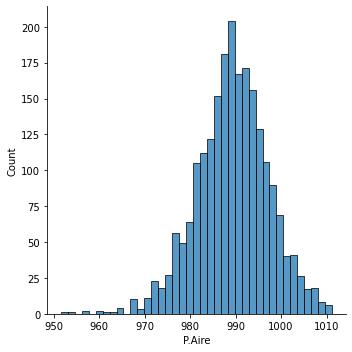

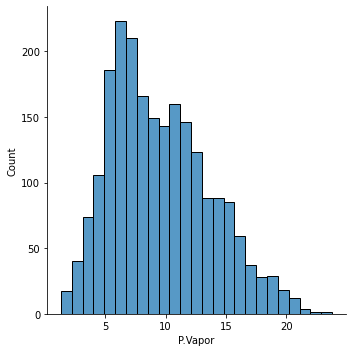

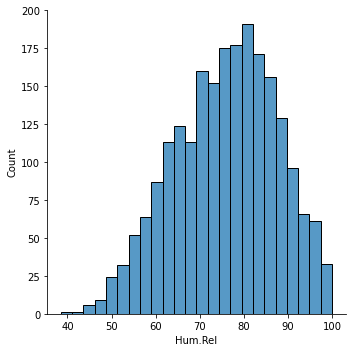

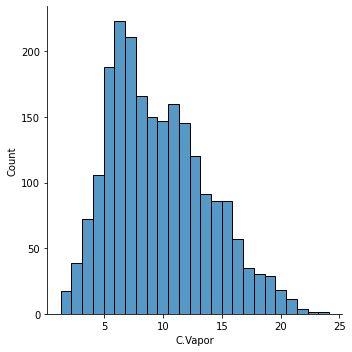

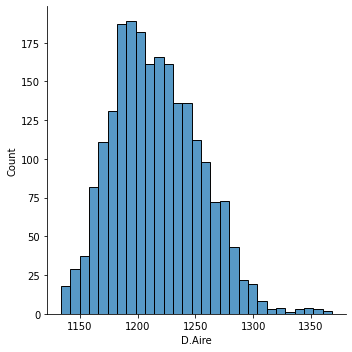

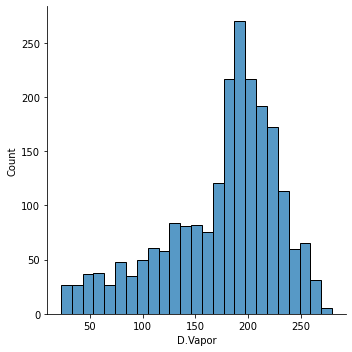

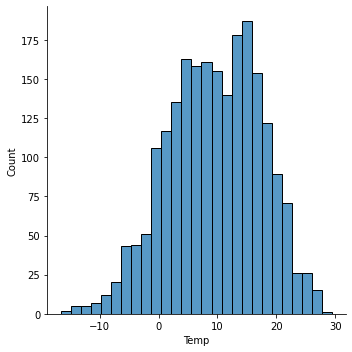

In [12]:
import matplotlib.pyplot as plt
for col in df.columns[1:]:
    df[col] = df[col].round(decimals=2) # Redondeo de los valores a 0 decimales
    # df[col] = df[col].astype(int)       # Las predicciones no reciben float
    sns.displot(df, x=col)

In [13]:
df.describe()

,P.Aire,P.Vapor,Hum.Rel,C.Vapor,D.Aire,D.Vapor,Temp
count,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000
mean,989.291952,9.528664,75.839558,9.635121,1216.120219,174.249950,9.462321
std,7.913174,4.106531,11.592708,4.157923,37.622388,54.484004,7.861140
min,951.560000,1.300000,38.500000,1.290000,1133.430000,22.570000,-16.580000
25%,984.380000,6.280000,67.520000,6.340000,1188.260000,141.960000,3.900000
50%,989.460000,8.910000,76.750000,8.980000,1212.650000,187.760000,9.720000
75%,994.390000,12.230000,84.440000,12.360000,1242.080000,211.460000,15.360000
max,1011.200000,23.800000,100.000000,24.120000,1368.360000,279.370000,29.450000


Se busca ahora comenzar a generar el corte transversal, haciendo variables promedio: 

# Parte 1: Modelos shallow (3 puntos)

Utilizando modelos shallow (por oposición a profundos), desarrolle modelos predictivos que permitan predecir la temperatura del séptimo día siguiente:

- No utilice modelos de forecasting como ARIMA o Holt-Winters
- Establezca variables a partir de los datos históricos. Por ejemplo, puede establecer datos como la temperatura promedio de los últimos 3 días, de los últimos 7 días, de los últimos 10 días, la presión del aire mínima de los últimos 3 días, de los últimos 7 días, de los últimos 15 días, los valores del día anterior de todas las variables, lo valores de hace 1 año en la misma fecha, etc.
- Debe crear un dataset de corte transversal, estimando las variables a utilizar cada día, o cada semana, o cada mes.
- Utilice modelos como SVM y redes neuronales artificiales tradicionales
- Utilice técnicas de seleccion de variables como PCA, LDA y Lasso
- Intente aplicar diferentes técnicas de normalización

<h1>1.1 Creación de los data sets

<h2>1.1.1 Creación del data frame de corte transversal 

- Definición de la ventada (7 días anteriores)
- Creación de las variables con base a la ventana para poder usarlo como una base de corte transversal:
    - Prom: Promedio de los últimos valores de la ventana
    - Max: Máximo de los últimos valores de la ventana
    - Min: Mínimo de los últimos valores de la ventana    

In [14]:
# Creamos un nuevo data frame para no modificar el original
df1 = pd.DataFrame()

# ventana = 3
# Generamos las variables de corte transversal
for ventana in [7,15,30]:
    for col in df.columns[1:]:
        prom = df[col].rolling(window=ventana).mean()
        nom_col = col + '.Prom.' + str(ventana) + ' días'
        df1[nom_col] = prom
        max  = df[col].rolling(window=ventana).max()
        nom_col = col + '.Max.' + str(ventana) + ' días'
        df1[nom_col] = max
        min  = df[col].rolling(window=ventana).min()
        nom_col = col + '.Min.' + str(ventana) + ' días'
        df1[nom_col] = min 

# Agregamos la variable dependiente (Temperatura del septimo día)
target = df.iloc[6:,len(df.columns)-1:]
target.reset_index(drop=True, inplace=True)
df1['Temp.Target.7'] = target
# df1 = pd.concat([df1, df['Temp']], axis=1)

df1.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 64 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   P.Aire.Prom.7 días    2187 non-null   float64
 1   P.Aire.Max.7 días     2187 non-null   float64
 2   P.Aire.Min.7 días     2187 non-null   float64
 3   P.Vapor.Prom.7 días   2187 non-null   float64
 4   P.Vapor.Max.7 días    2187 non-null   float64
 5   P.Vapor.Min.7 días    2187 non-null   float64
 6   Hum.Rel.Prom.7 días   2187 non-null   float64
 7   Hum.Rel.Max.7 días    2187 non-null   float64
 8   Hum.Rel.Min.7 días    2187 non-null   float64
 9   C.Vapor.Prom.7 días   2187 non-null   float64
 10  C.Vapor.Max.7 días    2187 non-null   float64
 11  C.Vapor.Min.7 días    2187 non-null   float64
 12  D.Aire.Prom.7 días    2187 non-null   float64
 13  D.Aire.Max.7 días     2187 non-null   float64
 14  D.Aire.Min.7 días     2187 non-null   float64
 15  D.Vapor.Prom.7 días  

<h2>1.1.2 Limpieza de datos

In [15]:
df1.head()

,P.Aire.Prom.7 días,P.Aire.Max.7 días,P.Aire.Min.7 días,P.Vapor.Prom.7 días,P.Vapor.Max.7 días,P.Vapor.Min.7 días,Hum.Rel.Prom.7 días,Hum.Rel.Max.7 días,Hum.Rel.Min.7 días,C.Vapor.Prom.7 días,...,D.Aire.Prom.30 días,D.Aire.Max.30 días,D.Aire.Min.30 días,D.Vapor.Prom.30 días,D.Vapor.Max.30 días,D.Vapor.Min.30 días,Temp.Prom.30 días,Temp.Max.30 días,Temp.Min.30 días,Temp.Target.7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.39
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.46
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.28
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.18
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.80


- Eliminar los registros con variables nulas generados por los primeros N registros menores a la ventana 

In [16]:
df1.dropna(inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2158 entries, 29 to 2186
Data columns (total 64 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   P.Aire.Prom.7 días    2158 non-null   float64
 1   P.Aire.Max.7 días     2158 non-null   float64
 2   P.Aire.Min.7 días     2158 non-null   float64
 3   P.Vapor.Prom.7 días   2158 non-null   float64
 4   P.Vapor.Max.7 días    2158 non-null   float64
 5   P.Vapor.Min.7 días    2158 non-null   float64
 6   Hum.Rel.Prom.7 días   2158 non-null   float64
 7   Hum.Rel.Max.7 días    2158 non-null   float64
 8   Hum.Rel.Min.7 días    2158 non-null   float64
 9   C.Vapor.Prom.7 días   2158 non-null   float64
 10  C.Vapor.Max.7 días    2158 non-null   float64
 11  C.Vapor.Min.7 días    2158 non-null   float64
 12  D.Aire.Prom.7 días    2158 non-null   float64
 13  D.Aire.Max.7 días     2158 non-null   float64
 14  D.Aire.Min.7 días     2158 non-null   float64
 15  D.Vapor.Prom.7 días 

In [17]:
df1.reset_index(drop=True, inplace=True)
df1.head()

,P.Aire.Prom.7 días,P.Aire.Max.7 días,P.Aire.Min.7 días,P.Vapor.Prom.7 días,P.Vapor.Max.7 días,P.Vapor.Min.7 días,Hum.Rel.Prom.7 días,Hum.Rel.Max.7 días,Hum.Rel.Min.7 días,C.Vapor.Prom.7 días,...,D.Aire.Prom.30 días,D.Aire.Max.30 días,D.Aire.Min.30 días,D.Vapor.Prom.30 días,D.Vapor.Max.30 días,D.Vapor.Min.30 días,Temp.Prom.30 días,Temp.Max.30 días,Temp.Min.30 días,Temp.Target.7
0,986.467143,1009.92,960.67,3.432857,4.98,1.95,78.735714,81.5,73.85,3.502857,...,1282.296667,1347.08,1222.7,142.735333,248.07,31.43,-5.013333,2.15,-12.16,-0.71
1,983.214286,1009.92,960.67,3.472857,4.98,1.95,78.887143,81.5,73.85,3.555714,...,1282.703000,1347.08,1222.7,147.014000,248.07,31.43,-5.041000,2.15,-12.16,-0.01
2,980.221429,1009.92,960.67,3.587143,4.98,1.95,78.427143,81.5,73.85,3.680000,...,1281.988333,1347.08,1222.7,146.249667,248.07,31.43,-4.936667,2.15,-12.16,-5.17
3,976.165714,997.00,960.67,3.898571,4.98,2.03,77.612857,81.5,73.85,4.005714,...,1281.145333,1347.08,1222.7,148.896667,248.07,31.43,-4.839333,2.15,-12.16,-7.13
4,973.822857,981.53,960.67,4.310000,4.98,3.45,78.262857,81.5,75.26,4.428571,...,1279.729667,1347.08,1222.7,151.882333,248.07,31.43,-4.618333,2.15,-12.16,-6.81


<h2>1.1.3 Particionamiento de los datos

- Reordenar aleatoriamente los registros del data frame de corte transversal
- Particionar el data frame en 70% entrenamiento y 30% test

In [18]:
# Semilla para poder replicar el ejercicio
random_state = 40

In [19]:
#df1.reset_index(drop=True, inplace=True)

In [20]:
# X_train = df1.iloc[:1530,:]
# X_train = X_train.sample(frac=1, random_state=random_state)
# y_train = X_train['Temp'] 
# X_train = X_train.iloc[:,:len(X_train.columns)-1]

# X_test = df1.iloc[:1530,:]
# y_test = X_test['Temp'] 
# X_test = X_test.iloc[:,:len(X_test.columns)-1]


X_train, X_test, y_train, y_test = train_test_split(df1.iloc[:,:len(df1.columns)-1], df1['Temp.Target.7'], train_size=0.7, shuffle=False)

In [21]:
X_train.head()
y_train.head()

0   -0.71
1   -0.01
2   -5.17
3   -7.13
4   -6.81
Name: Temp.Target.7, dtype: float64

In [22]:
# Modifica el orden de los datos de prueba pero conservando la relación entre las variable X y la Y
X_train = X_train.sample(frac=1, random_state =random_state)
y_train = y_train.sample(frac=1, random_state =random_state)

In [23]:
print(X_train.iloc[:,:1].head(),'\n')
print(type(y_train))
print(type(X_train))


      P.Aire.Prom.7 días
602           989.665714
1497          981.584286
1021          994.180000
621           987.332857
623           993.340000 

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


<h2> 1.2 Pipelines de entrenamiento y evaluación del mejor modelo

Para seleccionar el mejor modelo se compararán los algoritmos de PCA, LDA y Lasso con base a la métrica <u>accuracy</u>

Utilizando objetos **Pipeline**, encuentren el mejor modelo **SVC** para el dataset analizado. Haga diferentes intentos, variando:

- el tipo de normalización utilizada (Sin normalización, con **StandardScaler**)
- el tipo de reducción de dimensionalidad (Sin reducción, con **PCA**, con **LDA**), especificando None, 10, 15 y 20 dimensiones
- el tipo de kernel utilizado por un modelo **SVC** (linear, rbf, o sigmoid). El kernel poly, al tener 26 variables no es una opción viable.
- el valor del parámetro *C*
- el valor del parámetro *gamma* cuando aplique

Trabaje sobre el 70% de los datos, particionados de manera estratificada según la variable objetivo.

Utilice 'accuracy', como medida de evaluación de la calidad del ajuste de los modelos, usando el protocolo de evaluación de cross-validation con 5 folds.

Compare las curvas ROC AUC de los 2 mejores clasificadores encontrados.

In [24]:
metrica = "r2"

<h2>1.2.1 Modelos sin prepocesamiento

In [25]:
# n_alphas = 200
# alphas = np.logspace(-2, 2, n_alphas)

# steps = [('STD', StandardScaler()), 
#          ("LassoReg", Lasso(fit_intercept=True, normalize=False, max_iter=10000, tol=0.01))]
# pipeline = Pipeline(steps)
# parametros = {'LassoReg__alpha':alphas}
# grid3 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
# grid3.fit(X_train, y_train)
# print(grid3.best_params_)

steps = [('STD', StandardScaler()),
         ('PCA', PCA()),
         ("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)         
parametros = {'PCA__n_components':[None, 10, 15, 20], 'SVM_rbf__C':[0.01,0.1,1,10]}  
grid1 = GridSearchCV(pipeline, parametros, cv=5, scoring="r2") 
grid1.fit(X_train,y_train)     
print("score = %3.4f" %(grid1.score(X_test,y_test)))
print(grid1.best_params_)

score = 0.5664
{'PCA__n_components': None, 'SVM_rbf__C': 10}


In [26]:
# grid1.fit(X_train, y_train)

In [27]:
train_score1 = grid1.score(X_train, y_train)
test_score1 = grid1.score(X_test, y_test)
print ( "train: ", train_score1 , "test", test_score1)
#Overfitting 

train:  0.9082409952006731 test 0.5663606619118159


In [28]:
steps = [("SVM_linear", SVR(kernel="linear"))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10]}
grid2 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid2.fit(X_train,y_train)  
print("score = %3.4f" %(grid2.score(X_test,y_test)))
print(grid1.best_params_)

score = 0.5617
{'PCA__n_components': None, 'SVM_rbf__C': 10}


In [29]:
train_score2 = grid2.score(X_train, y_train)
test_score2 = grid2.score(X_test, y_test)
print ( "train: ", train_score2 , "test", test_score2)
#Overfitting (yet)

train:  0.7368758670812546 test 0.5617381196158351


In [30]:
steps = [("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5]}
grid3 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid3.fit(X_train,y_train)  
print("score = %3.4f" %(grid3.score(X_test,y_test)))
print(grid1.best_params_)

score = -0.1185
{'PCA__n_components': None, 'SVM_rbf__C': 10}


In [31]:
train_score3 = grid3.score(X_train, y_train)
test_score3 = grid3.score(X_test, y_test)
print ( "train: ", train_score3 , "test", test_score3)
#Overfitting (yet)

train:  0.951997947953693 test -0.11850704916362487


In [32]:
steps = [("SVM_sigmoid", SVR(kernel="sigmoid"))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5]}
grid4 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid4.fit(X_train,y_train)  
print("score = %3.4f" %(grid4.score(X_test,y_test)))
print(grid1.best_params_)

score = -0.1210
{'PCA__n_components': None, 'SVM_rbf__C': 10}


In [33]:
train_score4 = grid4.score(X_train, y_train)
test_score4 = grid4.score(X_test, y_test)
print ( "train: ", train_score3 , "test", test_score4)
#Overfitting (yet)

train:  0.951997947953693 test -0.1210235989516597


# Modelos con estandarización de los datos:

In [34]:
steps = [('STD', StandardScaler()), ("SVM_linear", SVR(kernel="linear"))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10]}
grid5 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid5.fit(X_train, y_train)
print("score = %3.4f" %(grid5.score(X_test,y_test)))
print(grid5.best_params_)

score = 0.5297
{'SVM_linear__C': 10}


In [35]:
train_score5 = grid5.score(X_train, y_train)
test_score5 = grid5.score(X_test, y_test)
print ( "train: ", train_score5 , "test", test_score5)
#Overfitting (yet)

train:  0.740328535971642 test 0.5297040003170035


In [36]:
steps = [('STD', StandardScaler()),("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5]}
grid6 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid6.fit(X_train, y_train)
print("score = %3.4f" %(grid6.score(X_test,y_test)))
print(grid6.best_params_)

score = 0.5203
{'SVM_rbf__C': 10, 'SVM_rbf__gamma': 0.05}


In [37]:
train_score6 = grid6.score(X_train, y_train)
test_score6 = grid6.score(X_test, y_test)
print ( "train: ", train_score6 , "test", test_score6)
#Overfitting (yet)

train:  0.9700754392432781 test 0.5203424483858672


In [38]:
steps = [('STD', StandardScaler()), ("SVM_sigmoid", SVR(kernel="sigmoid"))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5]}
grid7 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid7.fit(X_train, y_train)
print("score = %3.4f" %(grid7.score(X_test,y_test)))
print(grid7.best_params_)

score = 0.6383
{'SVM_sigmoid__C': 0.1, 'SVM_sigmoid__gamma': 0.01}


In [39]:
train_score7 = grid7.score(X_train, y_train)
test_score7 = grid7.score(X_test, y_test)
print ( "train: ", train_score7 , "test", test_score7)
#Overfitting (yet)

train:  0.6778519475954159 test 0.6382590485124491


### Modelos con estandarización de los datos y PCA:

In [40]:
steps = [('STD', StandardScaler()), ('PCA', PCA()), ("SVM_linear", SVR(kernel="linear"))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10], 'PCA__n_components':[None,10, 15, 20]}
grid8 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid8.fit(X_train, y_train)
print("score = %3.4f" %(grid8.score(X_test,y_test)))
print(grid8.best_params_)

score = 0.5297
{'PCA__n_components': None, 'SVM_linear__C': 10}


In [41]:
train_score8 = grid8.score(X_train, y_train)
test_score8 = grid8.score(X_test, y_test)
print ( "train: ", train_score8 , "test", test_score8)
#Overfitting (yet)

train:  0.7403285359717062 test 0.5297040003170521


In [42]:
steps = [('STD', StandardScaler()), ('PCA', PCA()), ("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5], 'PCA__n_components':[None, 10, 15, 20]}
grid9 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid9.fit(X_train, y_train)
print("score = %3.4f" %(grid9.score(X_test,y_test)))
print(grid9.best_params_)

score = 0.5203
{'PCA__n_components': None, 'SVM_rbf__C': 10, 'SVM_rbf__gamma': 0.05}


In [43]:
train_score9 = grid9.score(X_train, y_train)
test_score9 = grid9.score(X_test, y_test)
print ( "train: ", train_score9 , "test", test_score9)
#Overfitting (yet)

train:  0.9700754392432781 test 0.5203424483858659


In [44]:
steps = [('STD', StandardScaler()), ('PCA', PCA()), ("SVM_sigmoid", SVR(kernel="sigmoid"))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5], 'PCA__n_components':[None, 10, 15, 20]}
grid10 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid10.fit(X_train, y_train)
print("score = %3.4f" %(grid10.score(X_test,y_test)))
print(grid10.best_params_)

score = 0.6383
{'PCA__n_components': None, 'SVM_sigmoid__C': 0.1, 'SVM_sigmoid__gamma': 0.01}


In [45]:
train_score10 = grid10.score(X_train, y_train)
test_score10 = grid10.score(X_test, y_test)
print ( "train: ", train_score10 , "test", test_score10)
#Overfitting (yet)

train:  0.677851947595416 test 0.6382590485124492


### Modelos con estandarización de los datos y LDA:

In [46]:
X_train.shape

(1510, 63)

In [48]:
steps = [('STD', StandardScaler()), ('PCA', PCA()) , ("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'PCA__n_components':[None, 5, 10, 15, 20, 30], 'SVM_rbf__C':[0.001,0.01,0.1,1,10,100,1000]}
grid11 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid11.fit(X_train, y_train)
print("score = %3.4f" %(grid11.score(X_test,y_test)))
print(grid11.best_params_)

score = 0.1816
{'PCA__n_components': 20, 'SVM_rbf__C': 1000}


In [49]:
train_score11 = grid11.score(X_train, y_train)
test_score11 = grid11.score(X_test, y_test)
print ( "train: ", train_score11 , "test", test_score11)
#Overfitting (yet)

train:  0.9860503574127966 test 0.18157850613049764


# ¡¡Con LDA al parecer no se puede hacer nada por ser para clasificación!! al menos eso creo....


In [55]:
print ( "Grid1 "+"train: ", train_score1 , "\t test", test_score1)
print ( "Grid2 "+"train: ", train_score2 , "\t test", test_score2)
print ( "Grid3 "+"train: ", train_score3 , "\t test", test_score3)
print ( "Grid4 "+"train: ", train_score4 , "\t test", test_score4)
print ( "Grid5 "+"train: ", train_score5 , "\t test", test_score5)
print ( "Grid6 "+"train: ", train_score6 , "\t test", test_score6)
print ( "Grid7 "+"train: ", train_score7 , "\t test", test_score7)
print ( "Grid8 "+"train: ", train_score8 , "\t test", test_score8)
print ( "Grid9 "+"train: ", train_score9 , "\t test", test_score9)
print ( "Grid10 "+"train: ", train_score10 , "\t test", test_score10)
print ( "Grid11 "+"train: ", train_score11 , "\t test", test_score11)

# 7 y 10 (mejores, menos overfitting y además más cercano entre test y train)

Grid1 train:  0.9082409952006731 	 test 0.5663606619118159
Grid2 train:  0.7368758670812546 	 test 0.5617381196158351
Grid3 train:  0.951997947953693 	 test -0.11850704916362487
Grid4 train:  -4.565286143787262e-06 	 test -0.1210235989516597
Grid5 train:  0.740328535971642 	 test 0.5297040003170035
Grid6 train:  0.9700754392432781 	 test 0.5203424483858672
Grid7 train:  0.6778519475954159 	 test 0.6382590485124491
Grid8 train:  0.7403285359717062 	 test 0.5297040003170521
Grid9 train:  0.9700754392432781 	 test 0.5203424483858659
Grid10 train:  0.677851947595416 	 test 0.6382590485124492
Grid11 train:  0.9860503574127966 	 test 0.18157850613049764


In [ ]:
Considere los datos como una serie tiempo multivariada y utilice modelos de redes neuronales convolucionales para poder predecir la temperatura del séptimo día siguiente:

- Considere los datos como series de tiempo (no utilice modelos de forecasting como Arima o Holt-Winters, solo redes convolucionales). Debe buscar la mejor ventana de datos que le permita la mejor predicción
- Los datos deben ser transformados entonces en tensores de rango 3: (batch, ventana de tiempo, número de variables a predecir)
- Utilice filtros convolucionales de 1D. Defina una arquitectura con varias convolucionales 1D. Por ejemplo para ventanas de 60 días, se pueden definir en una primera capa 32 kernels de tamaño 3, 5, 7 días.
- Evalúe la utilidad del dropout para regularizar antes de la o las capas densas, intente varios valores.
- Evalúe la utilidad regularizar los kernels de las capas convolucionales con L1 o/y L2, intente varios valores.

In [ ]:
steps = [('STD', StandardScaler()), ('PCA', PCA()), ("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'PCA__n_components':[None,10, 15, 20]}
grid7 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid7.fit(X_train, y_train)
print("score = %3.4f" %(grid7.score(X_test,y_test)))
print(grid7.best_params_)